In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# Device configuration

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Data Preprocessing

In [3]:
# 학습 데이터에 대한 데이터 증강 및 정규화 정의
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

In [4]:
# 테스트 데이터에 대한 정규화 정의
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

In [5]:
# CIFAR-10 데이터셋 로드
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

100%|██████████| 170M/170M [00:05<00:00, 30.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
# 데이터셋 크기 및 클래스 확인
print(f"학습 데이터 샘플 수: {len(train_dataset)}")
print(f"테스트 데이터 샘플 수: {len(test_dataset)}")
print(f"클래스: {train_dataset.classes}")

학습 데이터 샘플 수: 50000
테스트 데이터 샘플 수: 10000
클래스: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
# 학습 데이터를 학습셋과 검증셋으로 나누기
train_indices, val_indices = train_test_split(
    list(range(len(train_dataset))), test_size=0.2, random_state=42
)
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

In [8]:
# 학습 및 테스트 데이터를 위한 DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# 2. Model Implementation

In [9]:
# CNN 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 합성곱 계층 정의
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),     #1
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),    #2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),   #3
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  #4
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),   #5
            nn.ReLU(),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),  #6
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )

        # 완전 연결 계층 정의
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [10]:
# 모델 인스턴스 생성
model = CNN().to(device)

# 3. Training

In [11]:
# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# 모델 학습 함수 정의
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_acc = []
    val_acc = []

    for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward & 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 정확도 계산
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_acc.append(train_accuracy)

        # Validation Accuracy 계산
        model.eval()  # 평가 모드
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_accuracy = 100 * correct / total
        val_acc.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

    return train_acc, val_acc

In [13]:
# 모델 학습
num_epochs = 10
train_acc, val_acc = train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Loss: 1.2859, Training Accuracy: 30.00%, Validation Accuracy: 44.34%
Epoch [2/10], Loss: 1.1742, Training Accuracy: 51.23%, Validation Accuracy: 58.81%
Epoch [3/10], Loss: 1.0557, Training Accuracy: 60.35%, Validation Accuracy: 66.64%
Epoch [4/10], Loss: 0.7028, Training Accuracy: 65.37%, Validation Accuracy: 71.53%
Epoch [5/10], Loss: 1.0266, Training Accuracy: 69.32%, Validation Accuracy: 70.79%
Epoch [6/10], Loss: 0.6976, Training Accuracy: 71.09%, Validation Accuracy: 73.75%
Epoch [7/10], Loss: 0.6763, Training Accuracy: 73.15%, Validation Accuracy: 78.27%
Epoch [8/10], Loss: 0.9398, Training Accuracy: 74.48%, Validation Accuracy: 78.94%
Epoch [9/10], Loss: 0.7986, Training Accuracy: 75.69%, Validation Accuracy: 78.69%
Epoch [10/10], Loss: 0.9001, Training Accuracy: 77.01%, Validation Accuracy: 80.44%


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48143 (\N{HANGUL SYLLABLE MIC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packa

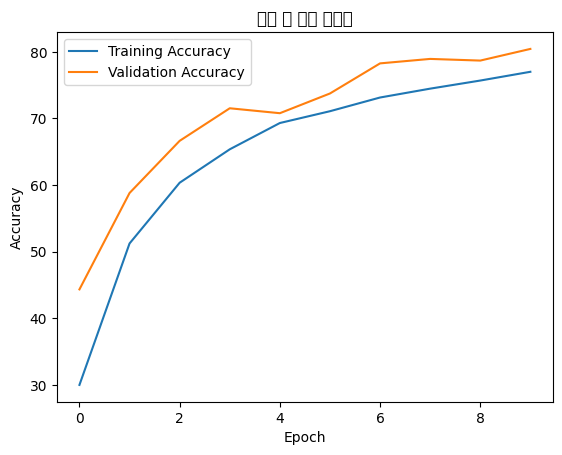

In [14]:
# 학습 및 검증 정확도 그래프
plt.plot(range(num_epochs), train_acc, label='Training Accuracy')
plt.plot(range(num_epochs), val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('학습 및 검증 정확도')
plt.legend()
plt.show()

#kfold 검정

In [15]:
from sklearn.model_selection import StratifiedKFold

In [23]:
def train_and_validate_kfold(model, dataset, criterion, optimizer, num_epochs=10, k_folds=5):
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    targets = np.array(dataset.targets)  # CIFAR-10 class labels

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(dataset)), targets)):
        print(f'Fold {fold + 1}/{k_folds}')
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=2)

        # 모델 초기화
        model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        model = model.to(device)

        # 각 폴드에서 학습
        for epoch in range(num_epochs):
            # 학습 루프
            model.train()
            correct, total = 0, 0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_accuracy = 100 * correct / total

            # 검증 루프
            model.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_accuracy = 100 * correct / total
            print(f"Epoch [{epoch + 1}/{num_epochs}] "
                  f"Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

        all_fold_metrics.append({'fold': fold, 'val_accuracy': val_accuracy})

    return all_fold_metrics

In [24]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
k_folds = 5
num_epochs = 10
fold_metrics = train_and_validate_kfold(model, train_dataset, criterion, optimizer, num_epochs, k_folds)

NameError: name 'np' is not defined

# 4. Evaluation

In [17]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [18]:
# 분류 보고서 생성
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# 5. 학습된 모델 저장
torch.save(model.state_dict(), 'cnn_cifar10.pth')
print("Model saved as cnn_cifar10.pth")

              precision    recall  f1-score   support

    airplane       0.83      0.80      0.82      1000
  automobile       0.88      0.92      0.90      1000
        bird       0.74      0.69      0.71      1000
         cat       0.61      0.69      0.64      1000
        deer       0.71      0.78      0.74      1000
         dog       0.82      0.60      0.69      1000
        frog       0.69      0.92      0.79      1000
       horse       0.92      0.70      0.79      1000
        ship       0.82      0.93      0.87      1000
       truck       0.92      0.80      0.85      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000

Model saved as cnn_cifar10.pth
